<div align='left' style="width:38%;overflow:hidden;">
<a href='http://inria.fr'>
<img src='https://github.com/lmarti/jupyter_custom/raw/master/imgs/inr_logo_rouge.png' alt='Inria logo' title='Inria'/>
</a>
</div>

# Machine Learning with `scikit-learn`

# 3. Linear Classification

## by [Nayat Sánchez Pi](http://www.nayatsanchezpi.com) and [Luis Martí](http://lmarti.com)

$\renewcommand{\vec}[1]{\boldsymbol{#1}}$

### About the notebook/slides

* The slides are _programmed_ as a [Jupyter](http://jupyter.org)/[IPython](https://ipython.org/) notebook.
* **Feel free to try them and experiment on your own by launching the notebooks.**

If you are using [nbviewer](http://nbviewer.jupyter.org) you can change to slides mode by clicking on the icon:

<div class="container-fluid">
  <div class="row">
      <div class="col-md-3"><span/></div>
      <div class="col-md-6">
              <img alt='view as slides' src='https://github.com/lmarti/jupyter_custom/raw/master/imgs/view-as-slides.png'/>
      </div>
      <div class="col-md-3" align='center'><span/></div>
  </div>
</div>

In [1]:
import random, math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
plt.rc('font', family='serif')

# numpy - pretty matrix 
np.set_printoptions(precision=3, threshold=1000, edgeitems=5, linewidth=80, suppress=True)

import seaborn
seaborn.set(style='whitegrid'); seaborn.set_context('talk')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Fixed seed to make the results replicable - remove in real life!
random.seed(42)

# Classification

* Given an input vector, $\vec{x}$, determine $p\left(\left. C_k\right|\vec{x}\right)$ where $k\in \{1\ldots K\}$ and $C_k$ is a discrete class label.
* We will discuss **linear models** for classification.

**Note:** the algorithms described here can also be applied to transformed input, $\phi(\vec{x})$, to determine $p\left(C_k\right|\left.\phi(\vec{x})\right)$, where $\phi(\cdot)$ may be a nonlinear transformation of the input space.

Our **first model assumption** is that our target output can be modeled as

$$y(\phi(\vec{x})) = f(\vec{w}^\intercal\phi(\vec{x}))$$

where $y$ will be a vector of probabilities with $K$ elements. 

* Elements of $\vec{y}$ are $y_k = p\left(C_k\right|\left.\phi\left(\vec{x}\right)\right)$ i.e. the probability that the correct class label is $C_k$ given the input vector $\vec{x}$. 
* Often we will have simply that $\vec{w}^\intercal\phi(\vec{x}) = \vec{w}^\intercal\vec{x}+w_0$ in which case we will simply omit $\phi()$ from the notation.
* The function $f()$ is known as the **activation function** and its inverse is known as the **link function**. 
* Note that $f()$ will often be nonlinear.

It should be noted that nearly all of the material presented fails to be a fully Bayesian treatment of the classification problem. Primarily this is because a Bayesian approach to the classification problem is mathematically intractable. However, Bayes' Theorem will appear often in the discussion, which can lead to confusion. Where appropriate, I will try to clarify the difference.

The target variable, $y$, does **not provide a decision** for a class assignment for a given input $\vec{x}$. 

* In real world cases where it is necessary to make a decision as to which class $\vec{x}$ should be assigned;
* one must apply an additional modeling step based on [*decision theory*](https://en.wikipedia.org/wiki/Decision_theory).

There are a variety of decision models, all of which leverage the class posterior probability models, $p\left(C_k\right|\left.\vec{x}\right)$, such as

* Minimizing the misclassification rate - this effectively corresponds to choosing the class with the highest probability for a given $\vec{x}$.
* Minimizing the expected loss - minimizes the expected value of a given loss function, $\ell(\cdot)$, under the class posterior probability distribution.
* Reject option.

## Linear classification models

The models discussed today are called *linear* because, 
* when the decision criteria is that of minimizing the misclassification rate, 
* they divide the input space into $K$ regions, 
* where the boundaries between regions are linear functions of the input vector $\vec{x}$. 
* The decision boundaries will correspond to where $\vec{w}^\intercal\vec{x}=\text{constant}$, and thus represent a linear function of $\vec{x}$. 
* In the case of transformed input, $\phi(\vec{x})$, the decision boundaries will correspond to where 
$\vec{w}^\intercal\phi(\vec{x})=\text{constant}$, and thus represent a linear function of $\phi(\vec{x})$. 

<div class="container-fluid">
  <div class="row">
      <div class="col-md-4"><span/></div>
      <div class="col-md-4">
              <img class='img-thumbnail' src='https://upload.wikimedia.org/wikipedia/commons/2/20/Svm_separating_hyperplanes.png'/>
      </div>
      <div class="col-md-4" align='center'><span/></div>
  </div>
</div>

# Probabilistic generative models

Our first step is to form a model of the class posterior probabilities for the *inference stage:*

This can be done by modeling: 
* the *class-conditional densities*, $p\left(\vec{x}\right|\left.C_k\right)$,
* the class priors, $p(C_k)$, and
* applying [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) to obtain the posterior model, or

*Note:* It can also be done directly, as in *probabilistic discriminative modeling* (forward pointer).

## Remembering Bayes' theorem

Bayes' theorem describes the probability of an event, based on conditions that might be related to the event.

$$ P\left(A\right|\left.B\right) = \frac{P\left(B\right|\left.A\right) \, P(A)}{P(B)}\,,$$
where $A$ and $B$ are events.

* $P(A)$ and $P(B)$ are the probabilities of $A$ and $B$ without regard to each other.
* $P\left( A \right|\left.B\right)$, a *conditional probability*, is the probability of observing event $A$ given that $B$ is true.
* $P\left(B\right|\left.A\right)$ is the probability of observing event $B$ given that $A$ is true.

* We will see that our class posterior probability model will depend only on the input $\vec{x}$...
* ...or a fixed transformation using basis functions $\phi()$, and
* class labels, $C_k$. 

In this case, for $K$ classes, our activation function will take the form of the *softmax function*,

$$
f_k = p\left(C_k\right|\left.\vec{x}\right) = 
\frac{p\left(\vec{x}\right|\left.C_k\right)p\left(C_k\right)}{p(\vec{x})} =
\frac{\exp(a_k)}{\sum_j \exp(a_j)}\,,
$$

where 

$$a_j = \ln\left(p\left(\vec{x}\right|\left.C_k\right)p(C_k)\right).$$

In the **case of $K=2$**, the activation function will reduce to the *logistic sigmoid* function

$$f(\vec{x}) = p\left(C_1\right|\left.\vec{x}\right) = \frac{1}{1+\exp(-a)} = \sigma(a)\,,$$

where 

$$a = \ln \frac {p\left(\vec{x}\right|\left. C_1\right)p(C_1)} {p\left(\vec{x}\right|\left. C_2\right)p\left(C_2\right)}\,.$$

* Note this is not the only possible form for the class posterior models. For example, one might also add a noise term to account for misclassification. 
* This particular form for the activation function is a consequence of the model we choose for $p(\vec{x}|C_k)$ in sections below. 
* Showing the outcome may be a bit of "putting the cart before the horse" but it will simplify the notation as we proceed.
* Although we have applied Bayes' Theorem, this is **not** a Bayesian model. 
    * Nowhere have we modeled the parameter posterior probability $p(\vec{w}|\vec{y})$. 
* Indeed, we will see shortly that we will use a *maximum likelihood* approach to determine $\vec{w}$.

These models are **known as generative models** because they can be used to generate synthetic input
data by applying [inverse transform sampling](http://en.wikipedia.org/wiki/Inverse_transform_sampling) to the marginal distribution for $\vec{x}$:

$$p(\vec{x}) = \sum_k p(\vec{x}|C_k)p(C_k)\,.$$

### Model assumptions

To move forward, it is necessary to start making **model assumptions**. 
Here we will *assume* that:
* we have continuous inputs, i.e. $x\in \mathbb{R}^n$ (see Bishop p.202 or Andrew Ng's Lecture 5 pdf for discrete input using Naïve Bayes & Laplace), and
* that the *class-conditional densities*, $p(\vec{x}|C_k)$, can be modeled by a Gaussian distribution. 

### Transformation under the Gaussian assumption

Under the Gaussian assumption, the class-conditional density  for class $C_k$ is

$$p(\vec{x}|C_k) = \frac{1}{\left(2 \pi \right)^{n/2}} \frac{1}{\left|\vec{\Sigma}\right|^{1/2}} \exp \left( -\frac{1}{2} \left(\vec{x} - \vec{\mu}_k\right)^\intercal \vec{\Sigma}^{-1} \left(\vec{x} - \vec{\mu}_k\right) \right)\,,$$

where:
* $n$ is the dimension of the input vector $\vec{x}$, 
* $\vec{\Sigma}$ is the *covariance matrix*, and
* $\vec{\mu}$ is the mean vector.

*Note:* here we have *assumed* that all classes share the same covariance matrix.

A [logistic function](https://en.wikipedia.org/wiki/Logistic_function) or logistic curve is a common "S" shape (sigmoid curve), defined as

$$\sigma(x)={\frac {L}{1+\exp(-k(x-x_{0}))}}\,,$$

where:

* $x_0$: the x-value of the sigmoid's midpoint,
* $L$: the curve's maximum value, and
* *k*: the steepness of the curve.

In the case of **two classes**, this result is substituted into the logistic sigmoid function and reduces to

$$p(C_1|\vec{x}) = \sigma \left( \vec{w}^\intercal \vec{x} + w_0 \right)$$

were we have defined: 

$$\vec{w} = \mathbf{\Sigma}^{-1} \left( \mathbf{\mu}_1 - \mathbf{\mu}_2 \right),$$

$$w_0 = -\frac{1}{2} \vec{\mu}_1^\intercal \vec{\Sigma}^{-1} \vec{\mu}_1 + \frac{1}{2} \vec{\mu}_2^\intercal \vec{\Sigma}^{-1} \vec{\mu}_2 + \ln \frac{p(C_1)} {p(C_2)}$$

### What about  $p(C_k)$?

* The class prior probabilities, $p(C_k)$, effectively act as a bias term. 
* Note that we have yet to specify a model for these distributions. 

If we are to use the result above, we will need to make **another model assumption**. 
* We will *assume* that the *class priors* are modeled by a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) with $p(C_1)=\gamma$ and $p(C_2)=1-\gamma$. 

These results can be extended to the case of $K>2$ classes for which we obtain

$$a_k(\vec{x}) = \left[\vec{\Sigma}^{-1} \vec{\mu}_k \right]^\intercal \vec{x} - \frac{1}{2} \vec{\mu}_k^\intercal \vec{\Sigma}^{-1} \vec{\mu}_k + \ln p(C_k)$$

which is used in the first activation function provided at the begin of this section. 

### What about the posterior class densities?

We have not formulated a complete model for the posterior class densities, in that we have not yet solved for the model parameters, $\vec{\mu}$ and $\vec{\Sigma}$. 

We do that now using a **maximum likelihood** approach.

## Likelihood function

* A **function of the parameters** of a statistical model **given** some data.

The likelihood of a set of parameter values, $\theta$, given outcomes $x$, is the probability of those observed outcomes given those parameter values,

$$\mathcal{L}(\theta |x)=P(x|\theta)$$
* Frequently, the natural logarithm of the likelihood function, called the **log-likelihood**, is more convenient to work with.

## Maximum Likelihood Solution

Considering the case of two classes, $C_1$ and $C_2$, with 
* Bernoulli prior distributions, $p(C_1)=\gamma$ and $p(C_2)=1-\gamma$, and
* Gaussian *class-conditional density* distributions $p(\vec{x}|C_k)$, 
* assume we have a training data set, $\Psi$, with $m$ elements of the form

$$\Psi = \left\{\left\langle\vec{x}_i, t_i\right\rangle\right\}$$

where $t_i=0$ indicates that $\vec{x_i}$ is in class $C_1$ and $t_i=1$ indicates that $\vec{x}_i$ is in class $C_2$.

The likelihood function is then given by

$$p\left(\vec{t}, \vec{X} \mid \gamma, \vec{\mu}_1, \vec{\mu}_2, \vec{\Sigma}\right) = \prod_{i=1}^m \left[\gamma \mathcal{N} \left(\vec{x}_i \mid \mu_1, \vec{\Sigma}\right)\right]^{t_i} \left[\left(1-\gamma\right) \mathcal{N}\left(\vec{x}_i \mid \mu_2, \vec{\Sigma}\right)\right]^{1-t_i}\,.$$ 

Taking the derivate of this expression with respect to the various model parameters, $\gamma$, $\mu_1$, $\mu_2$, and $\vec{\Sigma}$, and setting it equal to zero, we obtain

$$\gamma = \frac{N_1}{N_1+N_2}$$

where $N_1$ is the number of training inputs in class $C_1$ and $N_2$ is the number in class $C_2$.

#### similarly...

$$\mu_2 = \frac{1}{N_2} \sum_{i=1}^m t_i \vec{x}_i\,,$$
$$\mu_1 = \frac{1}{N_1} \sum_{i=1}^m (1-t_i) \vec{x}_i\,,\ \text{and}$$

$$\vec{\Sigma} = \frac{1}{m}\left[ \sum_{i\in C_1} (\vec{x}_i-\mu_1)(\vec{x}_i-\mu_1)^T + \sum_{i\in C_2} (\vec{x}_i-\mu_2)(\vec{x}_i-\mu_2)^T \right]\,.$$

## Example

* We will choose some *truth* values for our parameters and use our generative model to generate synthetic data. 
* We can then use that data as input to the maximum likelihood solution to see the estimates of the truth parameters. 
* Let's use 1-D input for simplicity. 
* We will be using a basic form of inverse transform sampling.
* Specifically, we wish for our training input data,  $\vec{x}$, to be derived from a distribution modeled by the marginal distribution $p(\vec{x})$.

* To obtain this, we first formulate the cumulative distribution function, 
$CDF(\vec{X}) = \int_{-\infty}^{\vec{X}} p(\vec{x})d\vec{x}$ (note that the range of the CDF is $[0,1]$).
* To obtain appropriately distributed $\vec{x}$ values, we choose some value from a uniform distribution on $[0,1]$, say $y$, and find the value $\vec{X}$ such that $CDF(\vec{X})=y$. 
* This value of $\vec{X}$ is our input $\vec{x}$.
* This approach requires us to find the inverse of the CDF, which we will do numerically.
* Once we have obtained a value for $\vec{x}$ we need to assign it to a particular class. 

We will *assume* that the correct class is that for which the posterior probability $p(\left.C_k\right|\vec{x})$ is greatest, **unless** the difference between the two posterior probabilities is less than some minimum value in which case we will chose randomly - this will add some "noise" to our input training data.

Select truth data values, these will *NOT* be known to the training algorithm, they are only used in generating the sample data.

In [4]:
true_mu1 =-2.0
true_mu2 = 2.0
true_sigma = 2.0
true_gamma = 0.5

In [5]:
import scipy.integrate as sci_intgr
import scipy.optimize as sci_opt

Defining probability functions

In [6]:
def p_xCk(x, mu, sigma):
    'Class conditional probability p(x|Ck)'
    denom = math.sqrt(2.0 * math.pi * sigma)
    arg = -0.5 * (x - mu) * (x - mu) / sigma
    return math.exp(arg) / denom

In [7]:
def p_x(x, mu1, mu2, sigma, gamma):
    'Marginal probability p(x)'
    return gamma * p_xCk(x, mu1, sigma) + (1.0 - gamma) * p_xCk(x, mu2, sigma)

In [8]:
def p_Ckx(x, mu1, mu2, sigma, gamma):
    'Posterior class probability vector (p(C_1|x), p(C_2|x))'
    a = math.log(p_xCk(x, mu1, sigma)*gamma/(p_xCk(x,mu2,sigma)*(1-gamma)))
    pc1 = 1.0/(1.0 + math.exp(-a))
    return (pc1, 1.0 - pc1)

In [9]:
def cdf(x, mu1, mu2, sigma, gamma):
    'Cumulative distribution function P(x<X)'
    return sci_intgr.quad(func=p_x, a=-np.inf, b=x, args=(mu1, mu2, sigma, gamma))

In [10]:
def inv_cdf(y, mu1, mu2, sigma, gamma):
    'Inverse of the CDF'
    f = lambda x: cdf(x,mu1,mu2,sigma,gamma)[0] - y
    return sci_opt.newton(f, 0)

Class conditional probabilities

In [11]:
domain = np.linspace(-5, 5, 100)

In [12]:
px_class1 = [p_xCk(x, true_mu1, true_sigma) for x in domain]
px_class2 = [p_xCk(x, true_mu2, true_sigma) for x in domain]

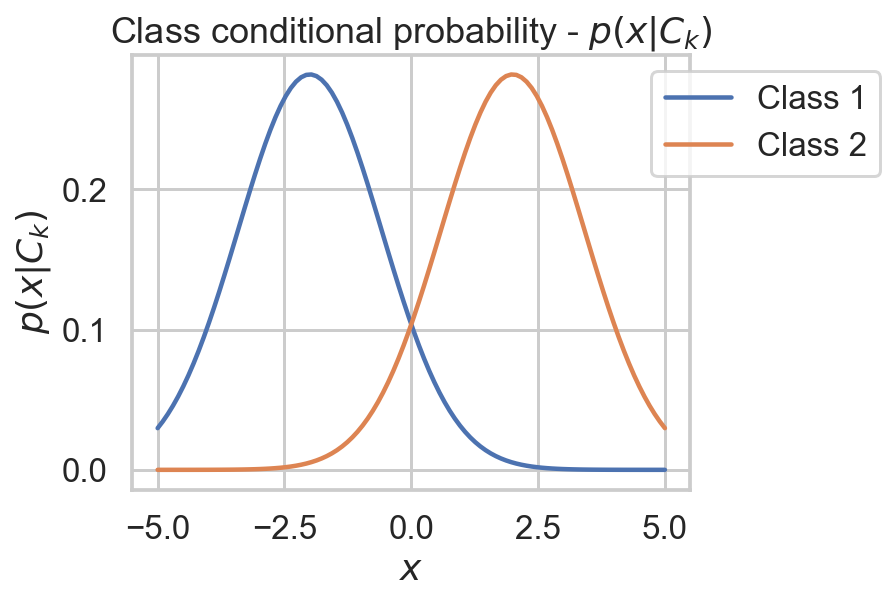

In [13]:
fig = plt.figure(figsize=(5,4))
plt.plot(domain, px_class1, label='Class 1')
plt.plot(domain, px_class2, label='Class 2')
plt.xlabel('$x$'); plt.ylabel('$p(x|C_k)$');plt.legend(bbox_to_anchor=(1.37,1), fancybox=True);
plt.title('Class conditional probability - $p(x|C_k)$');

Marginal distribution of $x$

In [14]:
px = [p_x(x, true_mu1, true_mu2, true_sigma, true_gamma) for x in domain]

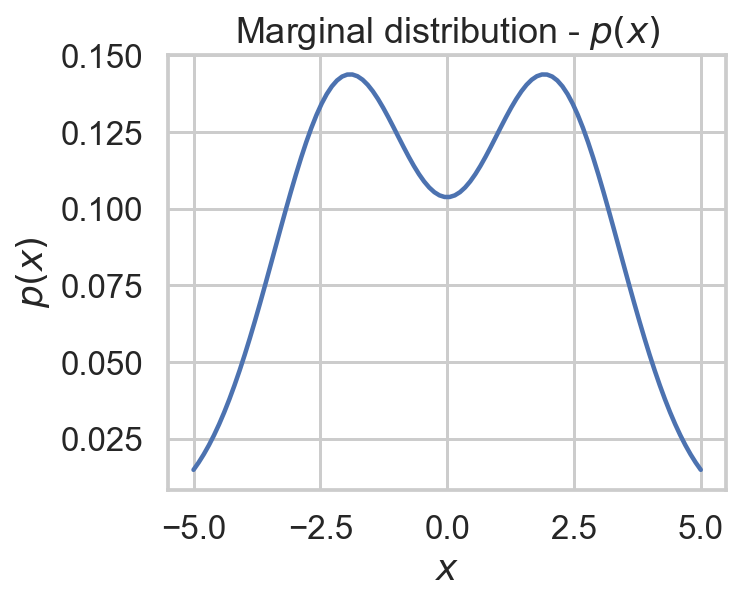

In [15]:
fig = plt.figure(figsize=(5,4))
plt.plot(domain,px)
plt.xlabel('$x$');plt.ylabel('$p(x)$');plt.title('Marginal distribution - $p(x)$');

Posterior distribution

In [16]:
pc1x, pc2x = [], []
for x in domain:
    pck = p_Ckx(x, true_mu1, true_mu2, true_sigma, true_gamma)
    pc1x.append(pck[0]); pc2x.append(pck[1])

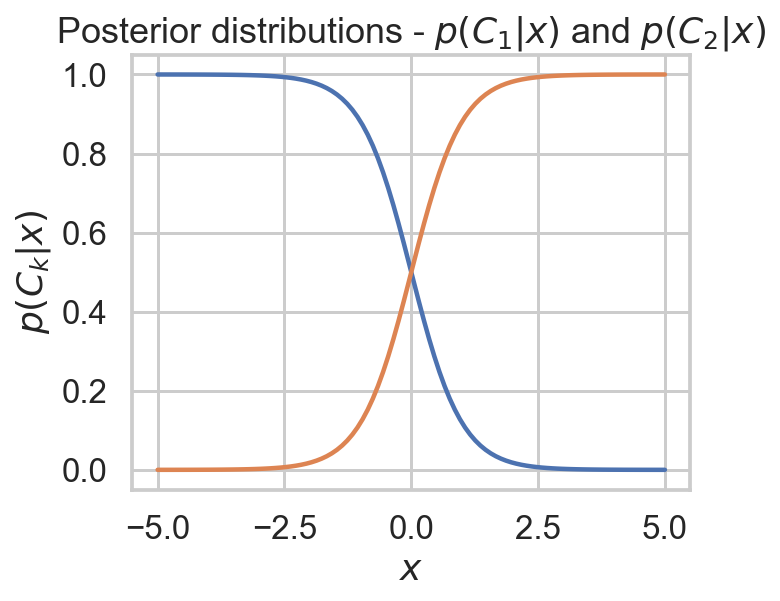

In [17]:
fig = plt.figure(figsize=(5,4))
plt.plot(domain, pc1x, label='Class 1')
plt.plot(domain, pc2x, label='Class 2')
plt.xlabel('$x$');plt.ylabel('$p(C_k|x)$');
plt.title('Posterior distributions - $p(C_1|x)$ and $p(C_2|x)$');

Or model is ready, let's generate some data and test it.

In [18]:
np.random.seed(123456789) # do not do this in real life
num_samples = 1000
x = np.zeros(num_samples)
t = np.zeros(num_samples)
pcx = np.zeros(num_samples)
n1 = 0
nae = 0
assignment_epsilon = 0.5

Assigning `x` to `1` for **class 1** and `0` for **class 2**.

In [19]:
for i in range(num_samples):
    rv = np.random.uniform()
    x[i] = inv_cdf(rv, true_mu1, true_mu2, true_sigma, true_gamma)
    pcx1 = p_Ckx(x[i], true_mu1, true_mu2, true_sigma, true_gamma)
    pcx2 = pcx1[1]
    pcx1 = pcx1[0]
    #we don't want a perfect dividing line for our domain, otherwise why would we need a learning algorithim?
    if math.fabs(pcx2-pcx1) <= assignment_epsilon:
        nae = nae + 1
        if np.random.uniform() <= 0.5:
            t[i] = 1
            n1 = n1 + 1
        else:
            t[i] = 0
    elif pcx1 > pcx2:
        t[i] = 1
        n1 = n1 + 1
    else: t[i]=0

### Plot the simulated data

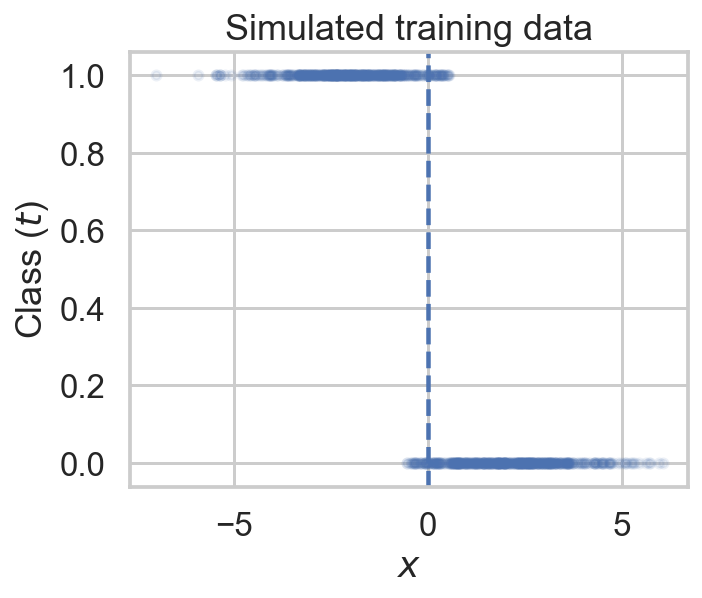

In [20]:
fig = plt.figure(figsize=(5,4))
plt.scatter(x, t, marker='.', alpha=0.1)
plt.axvline(0, linestyle='--')
plt.xlabel('$x$');plt.ylabel('Class ($t$)'); plt.title('Simulated training data');

## Estimating the parameters

In [21]:
n2 = num_samples - n1
e_gamma = n1/num_samples

In [22]:
e_mu1 = 0
for x_i, t_i in zip(x,t): 
    if t_i == 1:
        e_mu1 += x_i
    # e_mu1 += x_i*t_i
e_mu1 /= n1

In [23]:
e_mu2 = 0
for x_i, t_i in zip(x,t):
    if t_i == 0:
        e_mu2 += x_i
    # e_mu2 += x_i*(1-t_i)
e_mu2 /= n2

In [24]:
def Sn(Z, ck, mu=(e_mu1,e_mu2)):
    idx = 1-int(ck)
    return (Z[0]-mu[idx]) * (Z[0]-mu[idx])

In [25]:
e_sigma = 0
for x_i, t_i in zip(x,t): 
    e_sigma += Sn((x_i, t_i), t_i)
e_sigma /= float(num_samples)

In [26]:
print('The number of inputs in C1 is {0}'.format(n1))
print('The number of inputs that were assigned based on the assignment factor is {0}'.format(nae))
print('True model parameters: gamma={0}, µ1={1}, µ2={2}, ∑={3}'.format(true_gamma, 
                                                                       true_mu1, true_mu2, 
                                                                       true_sigma))
print('Estimated model parameters: gamma={0}, µ1={1}, µ2={2}, ∑={3}'.format(e_gamma, e_mu1, 
                                                                            e_mu2, e_sigma))

The number of inputs in C1 is 505
The number of inputs that were assigned based on the assignment factor is 121
True model parameters: gamma=0.5, µ1=-2.0, µ2=2.0, ∑=2.0
Estimated model parameters: gamma=0.505, µ1=-2.0692876157544364, µ2=2.095874429059065, ∑=1.724211126117565


# Probabilistic discriminative models

Probablistic discriminative models assume the same generalized linear model

$$y(\phi(\vec{x})) = f(\vec{w}^\intercal\phi(\vec{x}))$$

as in the probabilistic generative models. 

* Instead of formulating models for the *class-conditional* densities, $p\left(\phi(\vec{x})\right|\left.C_k\right)$, and the *class priors*, $p(C_k)$, 
* the discriminative approach explicitly models the *class posterior* probabilities, $p\left(C_k\right|\left.\phi(\vec{x})\right)$ with model parameters $\vec{w}$. 
* As in the probabilistic generative approach, maximum likelihood is used to estimate the model parameters given some training data set, $\Psi$.

The **key difference** is the form of the likelihood function. 
* In the **probabilistic generative case**, the likelihood function is a function of the joint probability,
$p\left(\phi(\vec{x}),C_k\right)=p\left(\phi(\vec{x})\right|\left.C_k\right)p(C_k)$. 
* In the **probabilistic discriminative approach**, the likelihood function is a function of the conditional class posteriors, $p\left(C_k\right|\left.\phi(\vec{x})\right)$ only.

*Note*: The section on probablistic generative models focused on models that used the input, $\vec{x}$, directly. However, as noted previously, those models, and the results, hold equally well for input that undergoes a **fixed** transformation using a set of basis functions, $\phi()$. In this section, we will focus on the inclusion of an input transformation via the basis functions.

## Logistic Regression

* Logistic regression is one specific example of discriminative modeling, for the case of **two classes**. 
* It assumes a model for the class posterior probabilities, $p(C_k|\phi(\vec{x}))$, in the form of the logistic sigmoid

$$p\left(C_1\right|\left.\phi(\vec{x})\right) = f(a) = \sigma\left(\vec{w}^\intercal\phi(\vec{x})\right)$$

with 

$$p\left(C_2\right|\left.\phi(\vec{x})\right) = 1 - p\left(C_1\right|\left.\phi(\vec{x})\right).$$

* We apply maximum likelihood to obtain the model parameters. 
* Assume that our training set is of the form $\Psi=\left\{\phi(\vec{x}_i),t_i\right\}$ where $t_i \in \{0,1\}$,
and $i=1,\ldots, m$. 
* The likelihood function of the training data is then
$$p(\Psi|\vec{w}) = \prod_{i=1}^m \sigma(\vec{w}^\intercal \phi(\vec{x}_i))^{t_i} (1 - \sigma(\vec{w}^\intercal \phi(\vec{x}_i)))^{(1-t_i)}$$

Defining the error function, $E(\vec{w})$, as the negative of the log-likelihood function, and taking the gradient with respect to $\vec{w}$, we obtain
$$\bigtriangledown E(\vec{w}) = \sum_{i=1}^m \left[\sigma(\vec{w}^\intercal \phi(\vec{x}_i)) - t_i\right] \phi(\vec{x}_i).$$

* this error function looks the same as that obtained for **linear** regression under the assumption of a Gaussian noise model which had a closed form solution.
* the nonlinearity of the *sigmoid* function, $\sigma\left(\vec{w}^\intercal \phi(\vec{x}_i)\right)$ prevents a closed form solution in the **logistic** regression problem. 
* We must apply an iterative method to obtain a numerical solution for the parameters, $\vec{w}$. 

Here we will consider the *Newton-Raphson* method for which minimizing the error function takes the form

$$\vec{w}^{(\tau+1)} = \vec{w}^{(\tau)} - \vec{H}^{-1}\bigtriangledown E(\vec{w}),$$

where $\vec{H}$ is the *Hessian* matrix composed of the second derivatives of the error function

$$\vec{H} = \bigtriangledown \bigtriangledown E(\vec{w}) = \Phi^\intercal \vec{R} \Phi,$$

where $\Phi$ is the $n \times m$ design matrix whose $n$-th row is given by $\phi(\vec{x_n})^\intercal$ and $\vec{R}$ is an $n \times n$ diagonal matrix with elements.

$$R_{i,i} = \sigma(\vec{w}^\intercal \phi(\vec{x}_i)) \left[1-\sigma(\vec{w}^\intercal \phi(\vec{x}_i))\right].$$ 

This can be reduced to a form equivalent to that of locally weighted linear *regression* as follows

$$\vec{w}^{(\tau+1)} = \left( \Phi^T \vec{R} \Phi \right)^{-1} \Phi^T \vec{R} \vec{z}$$

where $\vec{z}$ is an $n$-dimensional vector defined by

$$\vec{z} = \Phi \vec{w}^{(\tau)} - \vec{R}^{-1}(\vec{y} - \vec{t})$$

## Example 2

Let's consider an example with two classes and 2D input, $\vec{x}_n = (x_n^{(1)},x_n^{(2)})$. 

*  As an experiment, you can try increasing the number of training points, `N`. 
* Eventually, the training points will overlap so that it will not be possible to completely separate them with the transformation provided.

In [27]:
# preparing training dataset
np.random.seed(123456789) # fixing for reproducubility
N = 100 #number of data points
D = 2   #dimension of input vector
t = np.zeros(N) #training set classifications
X = np.zeros((N,D)) #training data in input space
sigma = .25
mu0 = 0.0
mu1 = 1.0

In [28]:
def create_scatter(X, t, ax):
    'Generates a two-class scatter plot'
    C1x, C1y, C2x, C2y = [], [], [], []
    for i in range(len(t)):
        if t[i] > 0: 
            C1x.append(X[i,0])
            C1y.append(X[i,1])
        else: 
            C2x.append(X[i,0])
            C2y.append(X[i,1])
    ax.scatter(C1x, C1y, c='b', alpha=0.5)
    ax.scatter(C2x, C2y, c='g', alpha=0.5)

### Generating test data

* Pick a value from a uniform distribution on $[0,1]$. 
* If it is less than 0.5, assign class 1 and pick $x_1, x_2$ from a $\mathcal{N}(\mu_0,\sigma)$ 
* otherwise assign class 2 and pick $x_1,x_2$ from $\mathcal{N}(\mu_1,\sigma)$

In [29]:
for i in range(N):
    #choose class to sample for
    fac = 1
    if np.random.rand() <= 0.5:
        thismu = mu0
        t[i] = 1
    else: 
        thismu = mu1
        t[i] = 0
        if np.random.rand() < 0.5: fac = -1
    X[i,0] = fac * np.random.normal(thismu, sigma)
    X[i,1] = fac * np.random.normal(thismu, sigma)

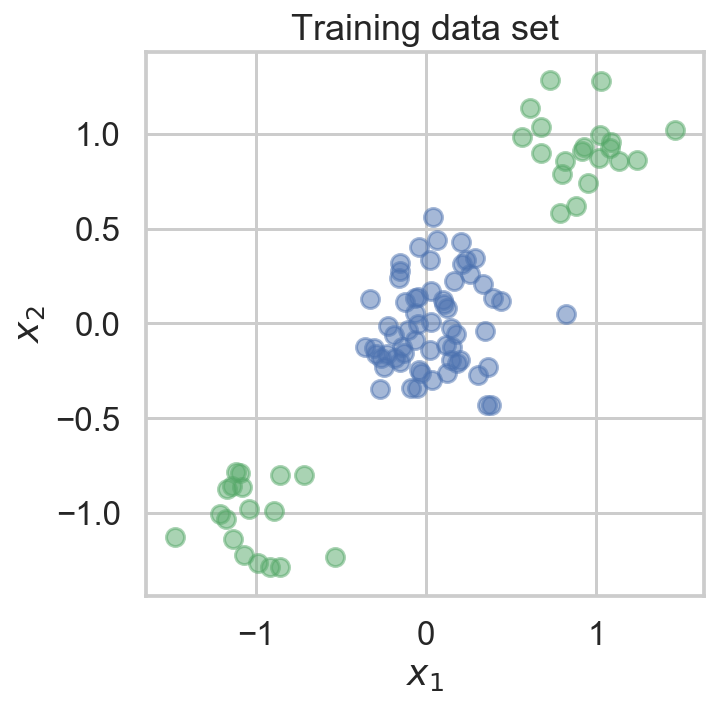

In [30]:
fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Training data set')
create_scatter(X, t, ax)

The training data does not have a linear boundary in the original input space.
* So lets apply a transformation, $\phi()$ (function `phi(...)`) to try to make it linearly separable
* *Note*: This transformation is not the only one that works. 
    * For example try switching the values of $\mu_1$ and $\mu_2$. 
    * The result will be a different mapping that is still linearly separable.

In [31]:
def phi(x, mu, sigma):
    detSigma = np.linalg.det(sigma)
    fac = math.pow(2 * math.pi, len(mu) / 2.0) * math.sqrt(detSigma)
    arg = -0.5 * np.dot((x - mu).T, np.dot(np.linalg.inv(sigma), x - mu))
    return math.exp(arg) / fac

In [32]:
phiX = np.zeros((N,D))
MU1 = np.ones(D)*mu0
MU2 = np.ones(D)*mu1
SIGMA = np.diag(np.ones(D))*sigma
for i in range(N):
    phiX[i,0] = phi(x=X[i,:], mu=MU2, sigma=SIGMA)
    phiX[i,1] = phi(x=X[i,:], mu=MU1, sigma=SIGMA)

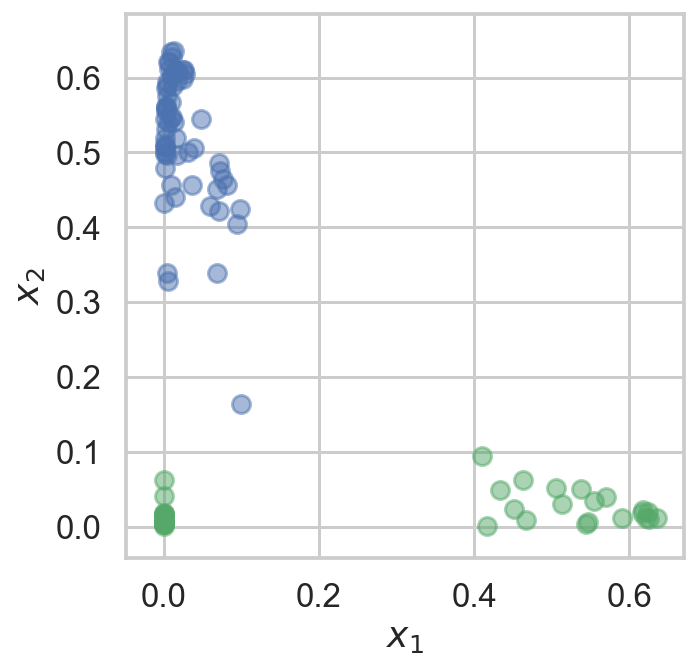

In [33]:
fig = plt.figure(figsize=(5,5)); ax =fig.gca()
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
create_scatter(phiX,t,ax)

Now, lets apply machine learning to determine the boundary!

* We will assume M = 3, i.e. that there are 3 free parameters,
* that is $\vec{w} = [w_0, w_1, w_2]^\intercal$ and,
* `phi_n = [1, phiX[0], phiX[1]]`.

In [34]:
M = 3
Phi = np.ones((N,M))
Phi[:,1] = phiX[:,0]
Phi[:,2] = phiX[:,1]
w = np.zeros(M)
R = np.zeros((N,N))
y = np.zeros(N)

In [35]:
def sigmoid(a):
    return 1.0 / (1.0 + math.exp(-a))

def totalErr(y,t):
    e = 0.0
    for i in range(len(y)):
        if t[i] > 0:
            e += math.log(y[i])
        else:
            e += math.log(1.0 - y[i])
    return -e

Starting Newton-Raphson. 

* As a stopping criteria we will use a tolerance on the change in the error function and a maximum number of iterations


In [36]:
max_its = 100
tol = 1e-2
w0 = [w[0]] 
w1 = [w[1]]
w2 = [w[2]]
err = []
error_delta = 1 + tol
current_error = 0
idx = 0

In [37]:
from functools import reduce

In [38]:
while math.fabs(error_delta) > tol and idx < max_its:
    #update y & R
    for i in range(N): 
        y[i] = sigmoid(reduce(lambda accum, Z: accum + Z[0]*Z[1], zip(w, Phi[i,:]), 0))
        R[i,i] = y[i] - y[i]*y[i]
    #update w
    z = np.dot(Phi,w) - np.dot(np.linalg.pinv(R),y-t)
    term_1 = np.linalg.pinv(np.dot(np.dot(Phi.T,R),Phi))
    term_2 = np.dot(np.dot(term_1, Phi.T),R)
    w = np.dot(term_2, z)
    w0.append(w[0])
    w1.append(w[1])
    w2.append(w[2])
    idx += 1
    temp = totalErr(y,t)
    error_delta = current_error - temp
    current_error = temp
    err.append(error_delta)

In [39]:
print('The total number of iterations was {0}'.format(idx))
print('The total error was {0}'.format(current_error))
print('The final change in error was {0}'.format(error_delta))
print('The final parameters were {0}'.format(w))

The total number of iterations was 13
The total error was 0.003482221426895694
The final change in error was 0.00577180168397616
The final parameters were [-17.844 -14.062 163.065]


Our decision boundary is now formed by the line where $\sigma(a) = 0.5$, i.e. where $a = 0$, which for this example is where $\phi_2 = -\frac{w_1}{w_2}\phi_1$, i.e. where $\vec{w} \cdot\vec{\phi} = 0.5$.


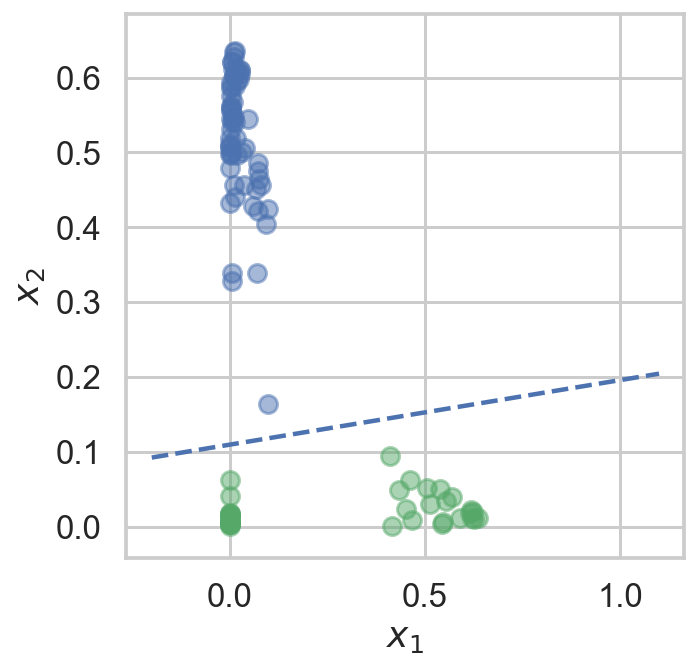

In [40]:
fig = plt.figure(figsize=(5,5)); ax =fig.gca()
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
create_scatter(phiX,t,ax)

bdryx = (-0.2,1.1)
bdryy = (-(w[0]+w[1]*bdryx[0])/w[2], -(w[0]+w[1]*bdryx[1])/w[2])
ax.plot(bdryx, bdryy, linestyle='--');

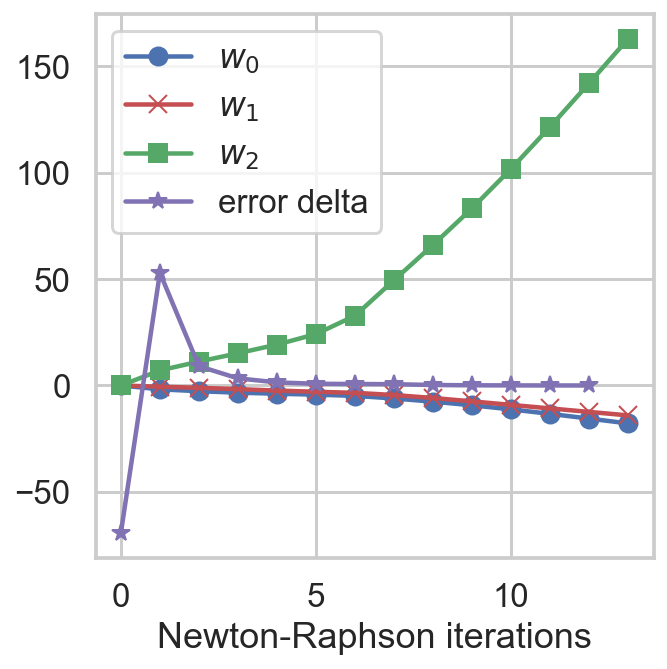

In [41]:
fig = plt.figure(figsize=(5,5))
plt.plot(w0, 'bo-', label='$w_0$')
plt.plot(w1, 'rx-', label='$w_1$')
plt.plot(w2, 'gs-', label='$w_2$')
plt.plot(err, 'm*-', label='error delta')
plt.legend(loc='upper left', frameon=True)
plt.xlabel('Newton-Raphson iterations');

<hr/>
<div class="container-fluid">
      <div class="row">
          <div class="col-md-3" align='center'>
              <img align='center' alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png"/>
          </div>
          <div class="col-md-9">
              This work is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/).
          </div>
      </div>
</div>

In [42]:
# this code is here for cosmetic reasons
from IPython.core.display import HTML
from urllib.request import urlopen
HTML(urlopen('https://raw.githubusercontent.com/lmarti/jupyter_custom/master/custom.include').read().decode('utf-8'))

In [43]:
%load_ext version_information
%version_information scipy, numpy, matplotlib

Software versions
Python 3.6.10 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.11.1
OS Darwin 19.2.0 x86_64 i386 64bit
scipy 1.3.2
numpy 1.18.1
matplotlib 3.1.1
Thu Jan 30 07:46:09 2020 -03

---